In [17]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import tensorflow as tf
import keras
from keras import layers
import time
import matplotlib.pyplot as plt
from FFNDLResearchModels import*
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

## Define the parameters for synthetic data generation

In [18]:
# Parameters
#nsamples = 500000
nsamples = 300000
generator = GenerateSyntheticData(nsamples)
dataset = generator.data() #features dataset
maturity, stockPrice, strikePrice, riskFreeRate, impliedVolatility, time_to_choose = dataset


#Using the csv file
#dataset = pd.read_csv("deep_synthetic_data.csv")
#maturity = dataset['Maturity']
#stockPrice = dataset['Stock Price']
#strikePrice = dataset['Strike Price']
#riskFreeRate = dataset['Risk-Free Rate']
#impliedVolatility = dataset['Implied Volatility']
#time_to_choose = dataset['Choice Time']

## All Three Structures 

In [19]:
#Zero-coupon bond
zcbPrice = ZeroCouponBond(maturity, riskFreeRate).price()

#vanilla European call option structure
vanillaCallOption = AnalyticalVanillaEuropeanOption(maturity, stockPrice, strikePrice, riskFreeRate, impliedVolatility, 'call')
analyticalCallPrice = vanillaCallOption.price()
analyticalCallDelta = vanillaCallOption.delta()
vanillaCallStructure = zcbPrice + analyticalCallPrice # capital guarantee structured product


#Chooser option structure
vanillaChooserOption = AnalyticalChooserOption(time_to_choose, maturity, stockPrice, strikePrice, riskFreeRate, impliedVolatility)
analyticalChooserPrice = vanillaChooserOption.price()
analyticalChooserDelta = vanillaChooserOption.delta()
vanillaChooserStructure = zcbPrice + analyticalChooserPrice # capital guarantee structured product


#Cash-or-nothing option structure
cashCallOption = AnalyticalVanillaEuropeanOption(maturity, stockPrice, strikePrice, riskFreeRate, impliedVolatility, 'call')
analyticalCashPrice = cashCallOption.price()
analyticalCashDelta = cashCallOption.delta()
vanillaCashStructure = zcbPrice + analyticalCashPrice # capital guarantee structured product

## Data normalization

In [20]:
#datasetTT = (dataset-dataset.min(axis=1, keepdims=True))/(dataset.max(axis=1, keepdims=True)-dataset.min(axis=1, keepdims=True))
dataset = scaler.fit_transform(dataset.T).T
# Assume data is the output matrix from the data method
withoutTimeToChooser_dataset = np.vstack((dataset[0], dataset[1], dataset[2], dataset[3], dataset[4]))

###vanilla European call option structure (price and delta)
analyticalCallDelta = scaler.fit_transform(analyticalCallDelta.reshape(-1, 1))
vanillaCallStructure = scaler.fit_transform(vanillaCallStructure.reshape(-1, 1))

###Chooser option structure (price and delta)
analyticalChooserDelta = scaler.fit_transform(analyticalChooserDelta.reshape(-1, 1))
vanillaChooserStructure = scaler.fit_transform(vanillaChooserStructure.reshape(-1, 1))

###Cash call option structure (price and delta)
analyticalCashDelta = scaler.fit_transform(analyticalCashDelta.reshape(-1, 1))
vanillaCashStructure = scaler.fit_transform(vanillaCashStructure.reshape(-1, 1))

## Splitting the data into training and validation

In [21]:
# Splitting vanilla European call option structure
X_trainCall, X_valCall, y_trainCall, y_valCall = train_test_split(withoutTimeToChooser_dataset.T, vanillaCallStructure, test_size=0.2) #the price of the structured product
X_trainDeltaCall, X_valDeltaCall, delta_trainCall, delta_valCall = train_test_split(withoutTimeToChooser_dataset.T, analyticalCallDelta, test_size=0.2) #the delta of the structured product

# Splitting Chooser option structure
X_trainChooser, X_valChooser, y_trainChooser, y_valChooser = train_test_split(dataset.T, vanillaChooserStructure, test_size=0.2) #the price of the structured product
X_trainDeltaChooser, X_valDeltaChooser, delta_trainChooser, delta_valChooser = train_test_split(dataset.T, analyticalChooserDelta, test_size=0.2) #the delta of the structured product

# Splitting Cash option structure
X_trainCash, X_valCash, y_trainCash, y_valCash = train_test_split(withoutTimeToChooser_dataset.T, vanillaCashStructure, test_size=0.2) #the price of the structured product
X_trainDeltaCash, X_valDeltaCash, delta_trainCash, delta_valCash = train_test_split(withoutTimeToChooser_dataset.T, analyticalCashDelta, test_size=0.2) #the delta of the structured product

# Pricing Results: FFNN model, GBR, and SVR

## Vanilla European call option structure

### FFNN model

In [22]:
# Define the neural network model for pricing
modelCallPrice = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(5,)),  
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')  # Output layer for option price
])

# Compile the model
modelCallPrice.compile(optimizer='adam', loss='mean_squared_error')


#start the timer
start_time = time.time()
# Train the model
modelCallPrice.fit(X_trainCall, y_trainCall, epochs=10, verbose=0)
#end the timer
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {np.round(training_time, 2)} seconds")

Training time: 107.73 seconds


### GBR model

In [23]:
# Create the model
gb_modelCallPrice = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)

#start the timer
start_time = time.time()
# Train the model
gb_modelCallPrice.fit(X_trainCall, y_trainCall.ravel())
#end the timer
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {np.round(training_time, 2)} seconds")

Training time: 162.27 seconds


### SVR model

In [24]:
svm_modelCallPrice = SVR(kernel='rbf', gamma='scale', coef0=0)

#start the timer
start_time = time.time()
# Train the model
svm_modelCallPrice.fit(X_trainCall, y_trainCall.ravel())
#end the timer
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {np.round(training_time, 2)} seconds")

Training time: 2.23 seconds


#### Print the predicted results

In [25]:
y_valCall.ravel(), modelCallPrice.predict(X_valCall).ravel(), gb_modelCallPrice.predict(X_valCall).ravel(), svm_modelCallPrice.predict(X_valCall).ravel()

1875/1875 [==============================] - 2s 930us/step


(array([0.7173067 , 0.27077627, 0.63706513, ..., 0.45538889, 0.64085217,
        0.00127716]),
 array([0.7275688 , 0.27382094, 0.63826233, ..., 0.4589702 , 0.64913696,
        0.00138075], dtype=float32),
 array([ 0.67928556,  0.24163418,  0.64894052, ...,  0.41600899,
         0.61600205, -0.05758288]),
 array([0.72628459, 0.23598533, 0.71192274, ..., 0.48432372, 0.68506233,
        0.02722892]))

1875/1875 [==============================] - 2s 986us/step


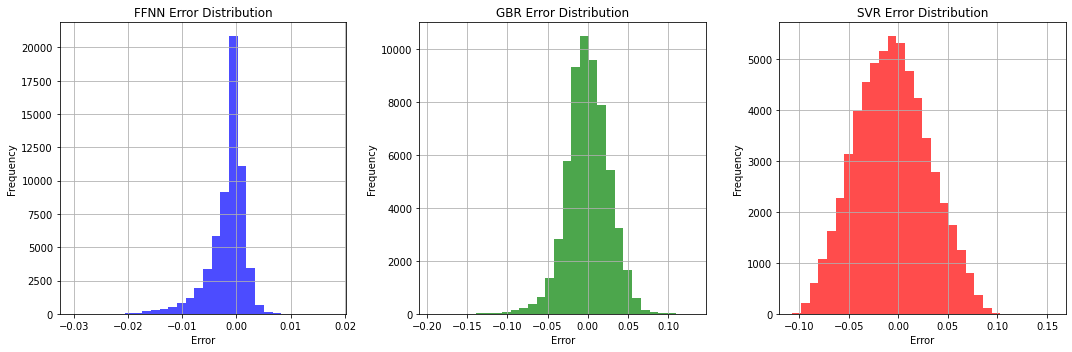

In [26]:
call_price_ffnn_error = y_valCall.ravel() - modelCallPrice.predict(X_valCall).ravel()
call_price_gbr_error = y_valCall.ravel() - gb_modelCallPrice.predict(X_valCall).ravel()
call_price_svr_error = y_valCall.ravel() - svm_modelCallPrice.predict(X_valCall).ravel()

# Plotting
plt.figure(figsize=(15, 5))

# FFNN Error Histogram
plt.subplot(1, 3, 1)
plt.hist(call_price_ffnn_error, bins=30, color='blue', alpha=0.7)
plt.title('FFNN Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid()

# GBR Error Histogram
plt.subplot(1, 3, 2)
plt.hist(call_price_gbr_error, bins=30, color='green', alpha=0.7)
plt.title('GBR Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid()

# SVR Error Histogram
plt.subplot(1, 3, 3)
plt.hist(call_price_svr_error, bins=30, color='red', alpha=0.7)
plt.title('SVR Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid()

plt.savefig("call_prices_errors.png", dpi=300)

plt.tight_layout()
plt.show()

## Chooser option structure

### FFNN model

In [27]:
# Define the neural network model for pricing
modelChooserPrice = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(6,)),  
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')  # Output layer for option price
])

# Compile the model
modelChooserPrice.compile(optimizer='adam', loss='mean_squared_error')

start_time = time.time()
# Train the model
modelChooserPrice.fit(X_trainChooser, y_trainChooser, epochs=10, verbose=0) #transpose the dataset
#end the timer
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {np.round(training_time,2)} seconds")

Training time: 82.83 seconds


### GBR model

In [28]:
# Create the model
gb_modelChooserPrice = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)

#start the timer
start_time = time.time()
# Train the model
gb_modelChooserPrice.fit(X_trainChooser, y_trainChooser.ravel())
#end the timer
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {np.round(training_time, 2)} seconds")

Training time: 154.1 seconds


### SVR model

In [29]:
svm_modelChooserPrice = SVR(kernel='rbf', gamma='scale', coef0=0)

#start the timer
start_time = time.time()
# Train the model
svm_modelChooserPrice.fit(X_trainChooser, y_trainChooser.ravel())
#end the timer
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {np.round(training_time, 2)} seconds")

Training time: 3.05 seconds


In [30]:
y_valChooser.ravel(), modelChooserPrice.predict(X_valChooser).ravel(), gb_modelChooserPrice.predict(X_valChooser), svm_modelChooserPrice.predict(X_valChooser)

1875/1875 [==============================] - 1s 669us/step


(array([0.21594573, 0.52321646, 0.41847212, ..., 0.27871384, 0.59553204,
        0.36594734]),
 array([0.2117225 , 0.51769936, 0.41928026, ..., 0.27744484, 0.5935524 ,
        0.36468285], dtype=float32),
 array([0.27328722, 0.5404471 , 0.41516428, ..., 0.18422779, 0.53445692,
        0.22882542]),
 array([0.20265933, 0.60556593, 0.35172488, ..., 0.21336543, 0.60669033,
        0.30988221]))

1875/1875 [==============================] - 1s 655us/step


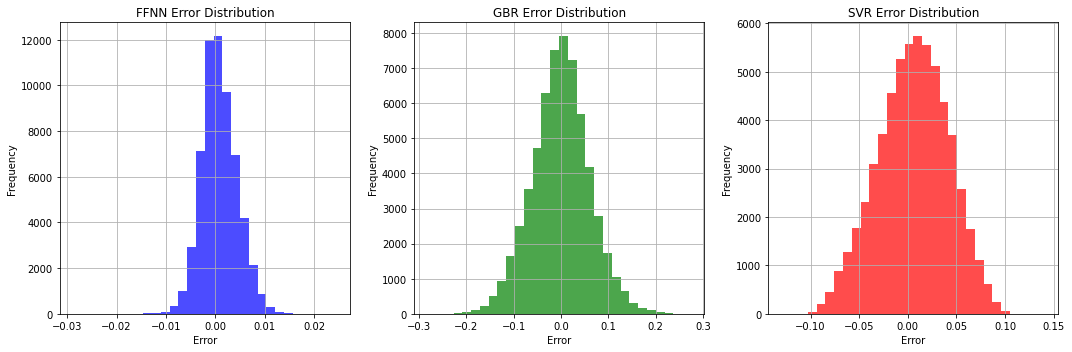

In [31]:
chooser_price_ffnn_error = y_valChooser.ravel() - modelChooserPrice.predict(X_valChooser).ravel()
chooser_price_gbr_error = y_valChooser.ravel() - gb_modelChooserPrice.predict(X_valChooser).ravel()
chooser_price_svr_error = y_valChooser.ravel() - svm_modelChooserPrice.predict(X_valChooser).ravel()

# Plotting
plt.figure(figsize=(15, 5))

# FFNN Error Histogram
plt.subplot(1, 3, 1)
plt.hist(chooser_price_ffnn_error, bins=30, color='blue', alpha=0.7)
plt.title('FFNN Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid()

# GBR Error Histogram
plt.subplot(1, 3, 2)
plt.hist(chooser_price_gbr_error, bins=30, color='green', alpha=0.7)
plt.title('GBR Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid()

# SVR Error Histogram
plt.subplot(1, 3, 3)
plt.hist(chooser_price_svr_error, bins=30, color='red', alpha=0.7)
plt.title('SVR Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid()

plt.savefig("chooser_prices_errors.png", dpi=300)

plt.tight_layout()
plt.show()

## Cash call option structure

### FFNN model

In [32]:
# Define the neural network model for pricing
modelCashPrice = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(5,)),  
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')  # Output layer for option price
])

# Compile the model
modelCashPrice.compile(optimizer='adam', loss='mean_squared_error')


start_time = time.time()
# Train the model
modelCashPrice.fit(X_trainCash, y_trainCash, epochs=10, verbose=0) #transpose the dataset
#end the timer
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {np.round(training_time,2)} seconds")

Training time: 68.57 seconds


## GBR model

In [33]:
# Create the model
gb_modelCashPrice = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)

#start the timer
start_time = time.time()
# Train the model
gb_modelCashPrice.fit(X_trainCash, y_trainCash.ravel())
#end the timer
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {np.round(training_time, 2)} seconds")

Training time: 121.31 seconds


### SVR model

In [34]:
svm_modelCashPrice = SVR(kernel='rbf', gamma='scale', coef0=0)

#start the timer
start_time = time.time()
# Train the model
svm_modelCashPrice.fit(X_trainCash, y_trainCash.ravel())
#end the timer
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {np.round(training_time, 2)} seconds")

Training time: 1.55 seconds


In [35]:
y_valCash.ravel(), modelCashPrice.predict(X_valCash).ravel(), gb_modelCashPrice.predict(X_valCash), svm_modelCashPrice.predict(X_valCash)

1875/1875 [==============================] - 1s 659us/step


(array([0.02891141, 0.22684968, 0.19448653, ..., 0.00903528, 0.37590401,
        0.68499334]),
 array([0.02993324, 0.22615872, 0.18990712, ..., 0.01032358, 0.3713082 ,
        0.6810886 ], dtype=float32),
 array([0.02990016, 0.2060108 , 0.15764025, ..., 0.03418728, 0.39633051,
        0.69059867]),
 array([0.02237478, 0.21256291, 0.17613927, ..., 0.03572945, 0.37949406,
        0.76178658]))

1875/1875 [==============================] - 2s 796us/step


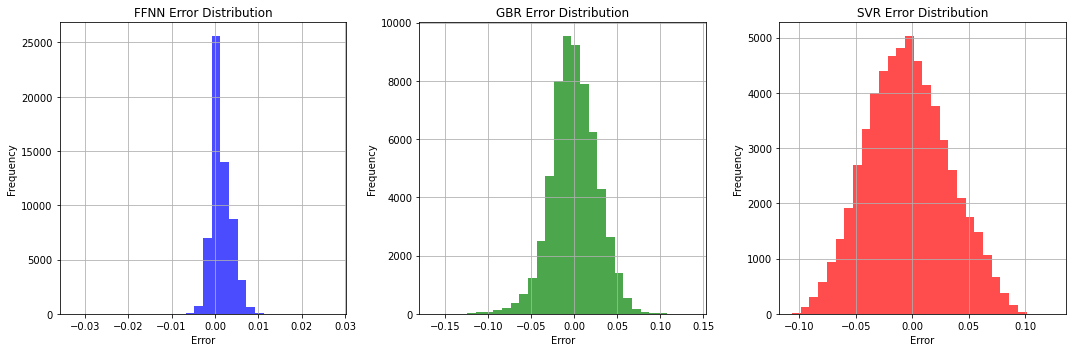

In [36]:
cash_price_ffnn_error = y_valCash.ravel() - modelCashPrice.predict(X_valCash).ravel()
cash_price_gbr_error = y_valCash.ravel() - gb_modelCashPrice.predict(X_valCash).ravel()
cash_price_svr_error = y_valCash.ravel() - svm_modelCashPrice.predict(X_valCash).ravel()

# Plotting
plt.figure(figsize=(15, 5))

# FFNN Error Histogram
plt.subplot(1, 3, 1)
plt.hist(cash_price_ffnn_error, bins=30, color='blue', alpha=0.7)
plt.title('FFNN Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid()

# GBR Error Histogram
plt.subplot(1, 3, 2)
plt.hist(cash_price_gbr_error, bins=30, color='green', alpha=0.7)
plt.title('GBR Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid()

# SVR Error Histogram
plt.subplot(1, 3, 3)
plt.hist(cash_price_svr_error, bins=30, color='red', alpha=0.7)
plt.title('SVR Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid()

plt.savefig("chooser_prices_errors.png", dpi=300)

plt.tight_layout()
plt.show()

## Validation of the Pricing models

### European structure

In [37]:
y_valCall.ravel(), modelCallPrice.predict(X_valCall).ravel(), gb_modelCallPrice.predict(X_valCall).ravel(), svm_modelCallPrice.predict(X_valCall).ravel()

1875/1875 [==============================] - 2s 1ms/step


(array([0.7173067 , 0.27077627, 0.63706513, ..., 0.45538889, 0.64085217,
        0.00127716]),
 array([0.7275688 , 0.27382094, 0.63826233, ..., 0.4589702 , 0.64913696,
        0.00138075], dtype=float32),
 array([ 0.67928556,  0.24163418,  0.64894052, ...,  0.41600899,
         0.61600205, -0.05758288]),
 array([0.72628459, 0.23598533, 0.71192274, ..., 0.48432372, 0.68506233,
        0.02722892]))

### Chooser structure

In [38]:
y_valChooser.ravel(), modelChooserPrice.predict(X_valChooser).ravel(), gb_modelChooserPrice.predict(X_valChooser).ravel(), svm_modelChooserPrice.predict(X_valChooser).ravel()

1875/1875 [==============================] - 2s 831us/step


(array([0.21594573, 0.52321646, 0.41847212, ..., 0.27871384, 0.59553204,
        0.36594734]),
 array([0.2117225 , 0.51769936, 0.41928026, ..., 0.27744484, 0.5935524 ,
        0.36468285], dtype=float32),
 array([0.27328722, 0.5404471 , 0.41516428, ..., 0.18422779, 0.53445692,
        0.22882542]),
 array([0.20265933, 0.60556593, 0.35172488, ..., 0.21336543, 0.60669033,
        0.30988221]))

### Cash structure

In [39]:
y_valCash.ravel(), modelCashPrice.predict(X_valCash).ravel(), gb_modelCashPrice.predict(X_valCash).ravel(), svm_modelCashPrice.predict(X_valCash).ravel() 

1875/1875 [==============================] - 2s 1ms/step


(array([0.02891141, 0.22684968, 0.19448653, ..., 0.00903528, 0.37590401,
        0.68499334]),
 array([0.02993324, 0.22615872, 0.18990712, ..., 0.01032358, 0.3713082 ,
        0.6810886 ], dtype=float32),
 array([0.02990016, 0.2060108 , 0.15764025, ..., 0.03418728, 0.39633051,
        0.69059867]),
 array([0.02237478, 0.21256291, 0.17613927, ..., 0.03572945, 0.37949406,
        0.76178658]))

# Validation: Price Error Distribution

1875/1875 [==============================] - 1s 723us/step


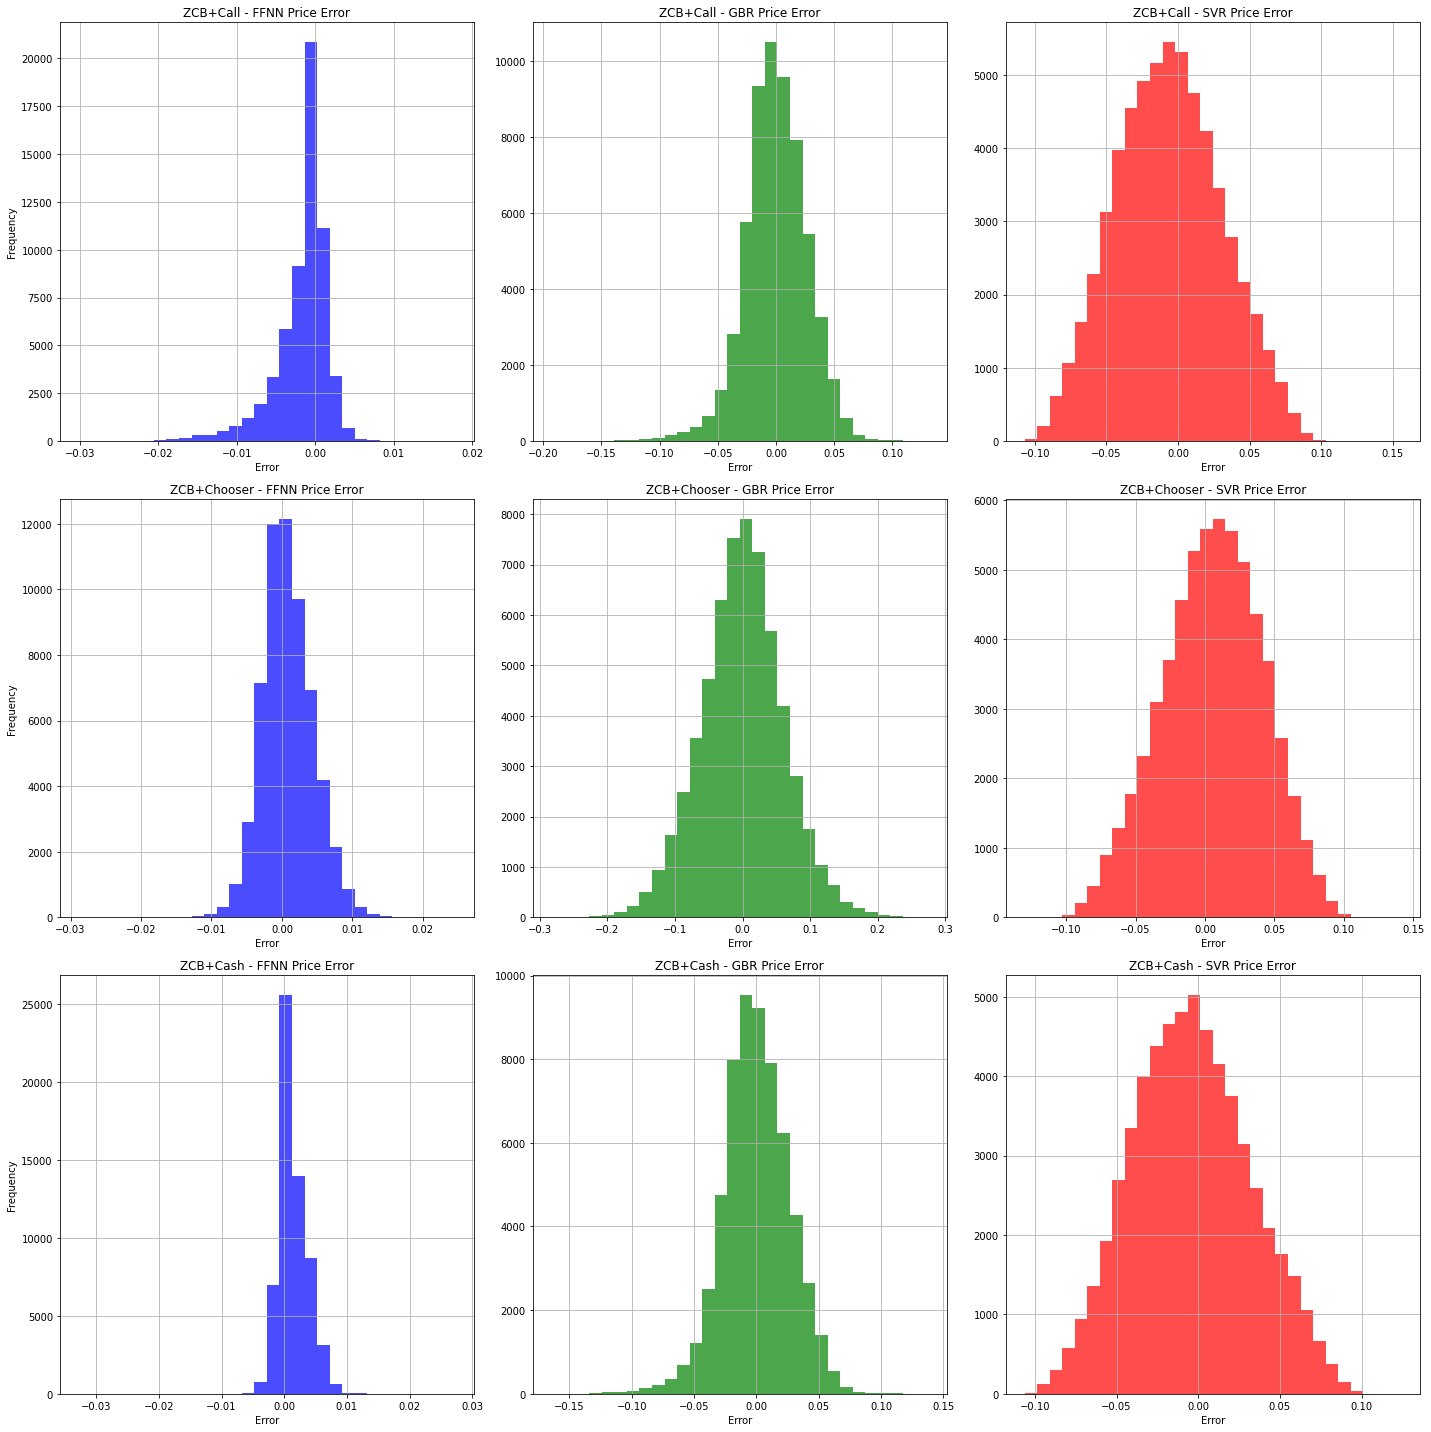

In [40]:
# ZCB + Call
y_valZCBCall = y_valCall.ravel()
ffnn_predZCBCall = modelCallPrice.predict(X_valCall).ravel()
gbr_predZCBCall = gb_modelCallPrice.predict(X_valCall).ravel()
svr_predZCBCall = svm_modelCallPrice.predict(X_valCall).ravel()

# ZCB + Chooser
y_valZCBChooser = y_valChooser.ravel()
ffnn_predZCBChooser = modelChooserPrice.predict(X_valChooser).ravel()
gbr_predZCBChooser = gb_modelChooserPrice.predict(X_valChooser).ravel()
svr_predZCBChooser = svm_modelChooserPrice.predict(X_valChooser).ravel()

# ZCB + Cash
y_valZCBCash = y_valCash.ravel()
ffnn_predZCBCash = modelCashPrice.predict(X_valCash).ravel()
gbr_predZCBCash = gb_modelCashPrice.predict(X_valCash).ravel()
svr_predZCBCash = svm_modelCashPrice.predict(X_valCash).ravel()

# Calculate errors for each product
ffnn_errorZCBCall = y_valZCBCall - ffnn_predZCBCall
gbr_errorZCBCall = y_valZCBCall - gbr_predZCBCall
svr_errorZCBCall = y_valZCBCall - svr_predZCBCall

ffnn_errorZCBChooser = y_valZCBChooser - ffnn_predZCBChooser
gbr_errorZCBChooser = y_valZCBChooser - gbr_predZCBChooser
svr_errorZCBChooser = y_valZCBChooser - svr_predZCBChooser

ffnn_errorZCBCash = y_valZCBCash - ffnn_predZCBCash
gbr_errorZCBCash = y_valZCBCash - gbr_predZCBCash
svr_errorZCBCash = y_valZCBCash - svr_predZCBCash

# Plotting
plt.figure(figsize=(20, 20))

# Error Histograms for ZCB + Call
plt.subplot(3, 3, 1)
plt.hist(ffnn_errorZCBCall, bins=30, color='blue', alpha=0.7)
plt.title('ZCB+Call - FFNN Price Error')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid()

plt.subplot(3, 3, 2)
plt.hist(gbr_errorZCBCall, bins=30, color='green', alpha=0.7)
plt.title('ZCB+Call - GBR Price Error')
plt.xlabel('Error')
plt.grid()

plt.subplot(3, 3, 3)
plt.hist(svr_errorZCBCall, bins=30, color='red', alpha=0.7)
plt.title('ZCB+Call - SVR Price Error')
plt.xlabel('Error')
plt.grid()

# Error Histograms for ZCB + Chooser
plt.subplot(3, 3, 4)
plt.hist(ffnn_errorZCBChooser, bins=30, color='blue', alpha=0.7)
plt.title('ZCB+Chooser - FFNN Price Error')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid()

plt.subplot(3, 3, 5)
plt.hist(gbr_errorZCBChooser, bins=30, color='green', alpha=0.7)
plt.title('ZCB+Chooser - GBR Price Error')
plt.xlabel('Error')
plt.grid()

plt.subplot(3, 3, 6)
plt.hist(svr_errorZCBChooser, bins=30, color='red', alpha=0.7)
plt.title('ZCB+Chooser - SVR Price Error')
plt.xlabel('Error')
plt.grid()

plt.subplot(3, 3, 7)
plt.hist(ffnn_errorZCBCash, bins=30, color='blue', alpha=0.7)
plt.title('ZCB+Cash - FFNN Price Error')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid()

plt.subplot(3, 3, 8)
plt.hist(gbr_errorZCBCash, bins=30, color='green', alpha=0.7)
plt.title('ZCB+Cash - GBR Price Error')
plt.xlabel('Error')
plt.grid()

plt.subplot(3, 3, 9)
plt.hist(svr_errorZCBCash, bins=30, color='red', alpha=0.7)
plt.title('ZCB+Cash - SVR Price Error')
plt.xlabel('Error')
plt.grid()

plt.savefig("prices_errors_distribution.png", dpi=300)

plt.tight_layout()
plt.show()

# Validation: Actual vs. Predicted

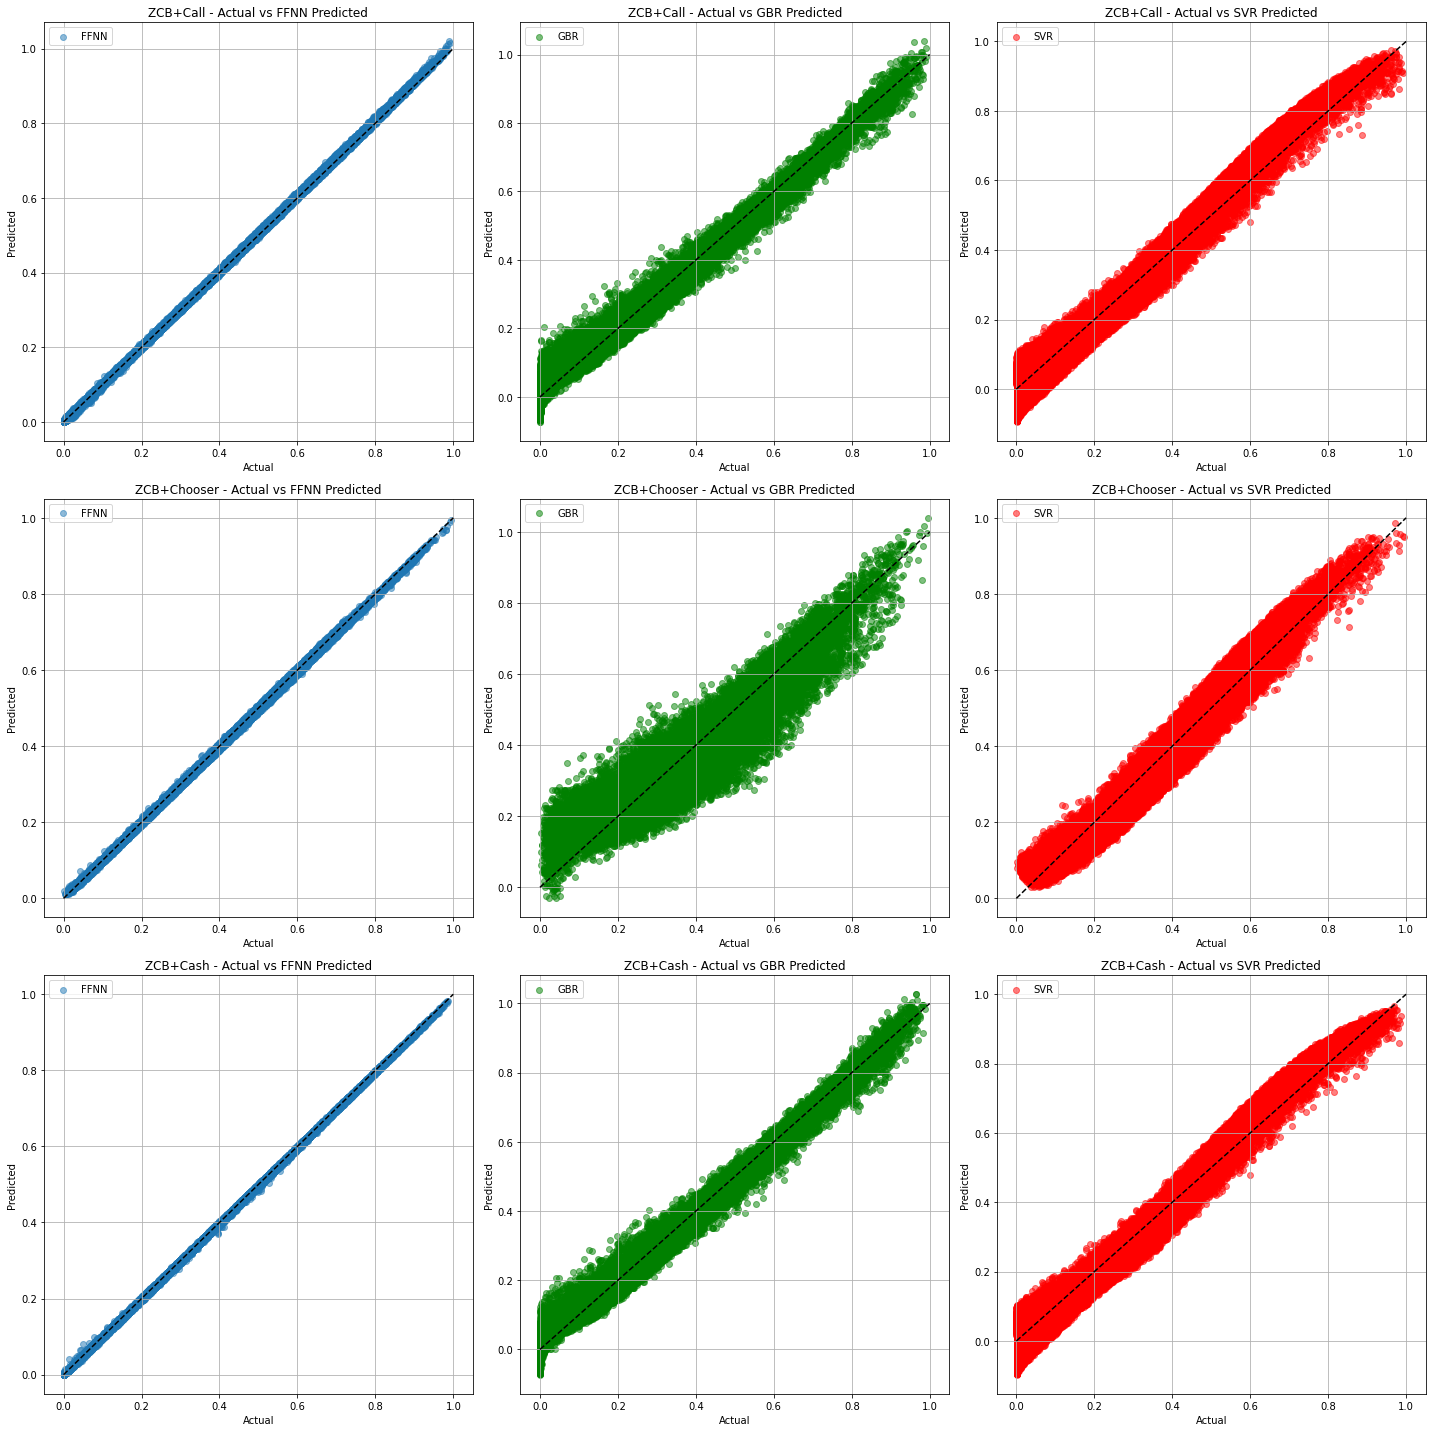

In [41]:
# Plotting
plt.figure(figsize=(20, 20))

# Actual vs Predicted for ZCB + Call
plt.subplot(3, 3, 1)
plt.scatter(y_valZCBCall, ffnn_predZCBCall, alpha=0.5, label='FFNN')
plt.plot([0, 1], [0, 1], 'k--')  # Ideal line
plt.title('ZCB+Call - Actual vs FFNN Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid()

plt.subplot(3, 3, 2)
plt.scatter(y_valZCBCall, gbr_predZCBCall, alpha=0.5, label='GBR', color='green')
plt.plot([0, 1], [0, 1], 'k--')  # Ideal line
plt.title('ZCB+Call - Actual vs GBR Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid()

plt.subplot(3, 3, 3)
plt.scatter(y_valZCBCall, svr_predZCBCall, alpha=0.5, label='SVR', color='red')
plt.plot([0, 1], [0, 1], 'k--')  # Ideal line
plt.title('ZCB+Call - Actual vs SVR Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid()

# Actual vs Predicted for ZCB + Chooser
plt.subplot(3, 3, 4)
plt.scatter(y_valZCBChooser, ffnn_predZCBChooser, alpha=0.5, label='FFNN')
plt.plot([0, 1], [0, 1], 'k--')  # Ideal line
plt.title('ZCB+Chooser - Actual vs FFNN Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid()

plt.subplot(3, 3, 5)
plt.scatter(y_valZCBChooser, gbr_predZCBChooser, alpha=0.5, label='GBR', color='green')
plt.plot([0, 1], [0, 1], 'k--')  # Ideal line
plt.title('ZCB+Chooser - Actual vs GBR Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid()

plt.subplot(3, 3, 6)
plt.scatter(y_valZCBChooser, svr_predZCBChooser, alpha=0.5, label='SVR', color='red')
plt.plot([0, 1], [0, 1], 'k--')  # Ideal line
plt.title('ZCB+Chooser - Actual vs SVR Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid()

# Actual vs Predicted for ZCB + Cash
plt.subplot(3, 3, 7)
plt.scatter(y_valZCBCash, ffnn_predZCBCash, alpha=0.5, label='FFNN')
plt.plot([0, 1], [0, 1], 'k--')  # Ideal line
plt.title('ZCB+Cash - Actual vs FFNN Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid()

plt.subplot(3, 3, 8)
plt.scatter(y_valZCBCash, gbr_predZCBCash, alpha=0.5, label='GBR', color='green')
plt.plot([0, 1], [0, 1], 'k--')  # Ideal line
plt.title('ZCB+Cash - Actual vs GBR Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid()

plt.subplot(3, 3, 9)
plt.scatter(y_valZCBCash, svr_predZCBCash, alpha=0.5, label='SVR', color='red')
plt.plot([0, 1], [0, 1], 'k--')  # Ideal line
plt.title('ZCB+Cash - Actual vs SVR Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid()

plt.savefig("prices_actual_predicted.png", dpi=300)

plt.tight_layout()
plt.show()

## Pricing: Evaluation metrics for all structures

### European call structure

In [42]:
# Calculate statistics for vanilla European call option
rmseCall = "{:.2e}".format(np.sqrt(mean_squared_error(y_valCall, modelCallPrice.predict(X_valCall))))
maeCall = "{:.2e}".format(mean_absolute_error(y_valCall, modelCallPrice.predict(X_valCall)))
mseCall = "{:.2e}".format(mean_squared_error(y_valCall, modelCallPrice.predict(X_valCall)))
r2Call = round(r2_score(y_valCall, modelCallPrice.predict(X_valCall)), 4)

print(f"Root Mean Squared Error (RMSE): {rmseCall}")
print(f"Mean Absolute Error (MAE): {maeCall}")
print(f"Mean Squared Error (MSE): {mseCall}")
print(f"R-squared: {r2Call}")

1875/1875 [==============================] - 2s 886us/step
Root Mean Squared Error (RMSE): 3.75e-03
Mean Absolute Error (MAE): 2.37e-03
Mean Squared Error (MSE): 1.41e-05
R-squared: 0.9997


In [43]:
# Calculate statistics for vanilla European call option
gb_rmseCall = "{:.2e}".format(np.sqrt(mean_squared_error(y_valCall, gb_modelCallPrice.predict(X_valCall))))
gb_maeCall = "{:.2e}".format(mean_absolute_error(y_valCall, gb_modelCallPrice.predict(X_valCall)))
gb_mseCall = "{:.2e}".format(mean_squared_error(y_valCall, gb_modelCallPrice.predict(X_valCall)))
gb_r2Call = round(r2_score(y_valCall, gb_modelCallPrice.predict(X_valCall)), 4)

print(f"Root Mean Squared Error (RMSE): {gb_rmseCall}")
print(f"Mean Absolute Error (MAE): {gb_maeCall}")
print(f"Mean Squared Error (MSE): {gb_mseCall}")
print(f"R-squared: {gb_r2Call}")

Root Mean Squared Error (RMSE): 2.62e-02
Mean Absolute Error (MAE): 2.03e-02
Mean Squared Error (MSE): 6.88e-04
R-squared: 0.987


In [44]:
# Calculate statistics for vanilla European call option
svm_rmseCall = "{:.2e}".format(np.sqrt(mean_squared_error(y_valCall, svm_modelCallPrice.predict(X_valCall))))
svm_maeCall = "{:.2e}".format(mean_absolute_error(y_valCall, svm_modelCallPrice.predict(X_valCall)))
svm_mseCall = "{:.2e}".format(mean_squared_error(y_valCall, svm_modelCallPrice.predict(X_valCall)))
svm_r2Call = round(r2_score(y_valCall, svm_modelCallPrice.predict(X_valCall)), 4)

print(f"Root Mean Squared Error (RMSE): {svm_rmseCall}")
print(f"Mean Absolute Error (MAE): {svm_maeCall}")
print(f"Mean Squared Error (MSE): {svm_mseCall}")
print(f"R-squared: {svm_r2Call}")

Root Mean Squared Error (RMSE): 3.73e-02
Mean Absolute Error (MAE): 3.04e-02
Mean Squared Error (MSE): 1.39e-03
R-squared: 0.9738


### Chooser structure

In [45]:
# Calculate statistics for Chooser option
rmseChooser = "{:.2e}".format(np.sqrt(mean_squared_error(y_valChooser, modelChooserPrice.predict(X_valChooser))))
maeChooser = "{:.2e}".format(mean_absolute_error(y_valChooser, modelChooserPrice.predict(X_valChooser)))
mseChooser = "{:.2e}".format(mean_squared_error(y_valChooser, modelChooserPrice.predict(X_valChooser)))
r2Chooser = round(r2_score(y_valChooser, modelChooserPrice.predict(X_valChooser)), 4)

print(f"Root Mean Squared Error (RMSE): {rmseChooser}")
print(f"Mean Absolute Error (MAE): {maeChooser}")
print(f"Mean Squared Error (MSE): {mseChooser}")
print(f"R-squared: {r2Chooser}")

1875/1875 [==============================] - 2s 978us/step
Root Mean Squared Error (RMSE): 3.68e-03
Mean Absolute Error (MAE): 2.85e-03
Mean Squared Error (MSE): 1.36e-05
R-squared: 0.9995


In [46]:
# Calculate statistics for vanilla European call option
gb_rmseChooser = "{:.2e}".format(np.sqrt(mean_squared_error(y_valChooser, gb_modelChooserPrice.predict(X_valChooser))))
gb_maeChooser = "{:.2e}".format(mean_absolute_error(y_valChooser, gb_modelChooserPrice.predict(X_valChooser)))
gb_mseChooser = "{:.2e}".format(mean_squared_error(y_valChooser, gb_modelChooserPrice.predict(X_valChooser)))
gb_r2Chooser = round(r2_score(y_valChooser, gb_modelChooserPrice.predict(X_valChooser)), 4)

print(f"Root Mean Squared Error (RMSE): {gb_rmseChooser}")
print(f"Mean Absolute Error (MAE): {gb_maeChooser}")
print(f"Mean Squared Error (MSE): {gb_mseChooser}")
print(f"R-squared: {gb_r2Chooser}")

Root Mean Squared Error (RMSE): 6.05e-02
Mean Absolute Error (MAE): 4.74e-02
Mean Squared Error (MSE): 3.67e-03
R-squared: 0.8778


In [47]:
# Calculate statistics for vanilla European call option
svm_rmseChooser = "{:.2e}".format(np.sqrt(mean_squared_error(y_valChooser, svm_modelChooserPrice.predict(X_valChooser))))
svm_maeChooser = "{:.2e}".format(mean_absolute_error(y_valChooser, svm_modelChooserPrice.predict(X_valChooser)))
svm_mseChooser = "{:.2e}".format(mean_squared_error(y_valChooser, svm_modelChooserPrice.predict(X_valChooser)))
svm_r2Chooser = round(r2_score(y_valChooser, svm_modelChooserPrice.predict(X_valChooser)), 4)

print(f"Root Mean Squared Error (RMSE): {svm_rmseChooser}")
print(f"Mean Absolute Error (MAE): {svm_maeChooser}")
print(f"Mean Squared Error (MSE): {svm_mseChooser}")
print(f"R-squared: {svm_r2Chooser}")

Root Mean Squared Error (RMSE): 3.66e-02
Mean Absolute Error (MAE): 2.98e-02
Mean Squared Error (MSE): 1.34e-03
R-squared: 0.9554


### Cash structure

In [48]:
# Calculate statistics for Cash call option
rmseCash = "{:.2e}".format(np.sqrt(mean_squared_error(y_valCash, modelCashPrice.predict(X_valCash))))
maeCash = "{:.2e}".format(mean_absolute_error(y_valCash, modelCashPrice.predict(X_valCash)))
mseCash = "{:.2e}".format(mean_squared_error(y_valCash, modelCashPrice.predict(X_valCash)))
r2Cash = round(r2_score(y_valCash, modelCashPrice.predict(X_valCash)), 4)

print(f"Root Mean Squared Error (RMSE): {rmseCash}")
print(f"Mean Absolute Error (MAE): {maeCash}")
print(f"Mean Squared Error (MSE): {mseCash}")
print(f"R-squared: {r2Cash}")

1875/1875 [==============================] - 2s 921us/step
Root Mean Squared Error (RMSE): 2.69e-03
Mean Absolute Error (MAE): 1.94e-03
Mean Squared Error (MSE): 7.23e-06
R-squared: 0.9999


In [49]:
# Calculate statistics for vanilla European call option
gb_rmseCash = "{:.2e}".format(np.sqrt(mean_squared_error(y_valCash, gb_modelCashPrice.predict(X_valCash))))
gb_maeCash = "{:.2e}".format(mean_absolute_error(y_valCash, gb_modelCashPrice.predict(X_valCash)))
gb_mseCash = "{:.2e}".format(mean_squared_error(y_valCash, gb_modelCashPrice.predict(X_valCash)))
gb_r2Cash = round(r2_score(y_valCash, gb_modelCashPrice.predict(X_valCash)), 4)

print(f"Root Mean Squared Error (RMSE): {gb_rmseCash}")
print(f"Mean Absolute Error (MAE): {gb_maeCash}")
print(f"Mean Squared Error (MSE): {gb_mseCash}")
print(f"R-squared: {gb_r2Cash}")

Root Mean Squared Error (RMSE): 2.66e-02
Mean Absolute Error (MAE): 2.07e-02
Mean Squared Error (MSE): 7.07e-04
R-squared: 0.9866


In [50]:
# Calculate statistics for vanilla European call option
svm_rmseCash = "{:.2e}".format(np.sqrt(mean_squared_error(y_valCash, svm_modelCashPrice.predict(X_valCash))))
svm_maeCash = "{:.2e}".format(mean_absolute_error(y_valCash, svm_modelCashPrice.predict(X_valCash)))
svm_mseCash = "{:.2e}".format(mean_squared_error(y_valCash, svm_modelCashPrice.predict(X_valCash)))
svm_r2Cash = round(r2_score(y_valCash, svm_modelCashPrice.predict(X_valCash)), 4)

print(f"Root Mean Squared Error (RMSE): {svm_rmseCash}")
print(f"Mean Absolute Error (MAE): {svm_maeCash}")
print(f"Mean Squared Error (MSE): {svm_mseCash}")
print(f"R-squared: {svm_r2Cash}")

Root Mean Squared Error (RMSE): 3.63e-02
Mean Absolute Error (MAE): 2.96e-02
Mean Squared Error (MSE): 1.32e-03
R-squared: 0.9751


# Hedging Results: FFNN model, GBR, and SVR

## Vanilla European call option structure

### FFNN model

In [51]:
# Define the neural network model for hedging
modelCallHedge = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(5,)),  
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')  # Output layer for the hedge
])

modelCallHedge.compile(optimizer='adam', loss='mean_squared_error')

start_time = time.time()
# Train the model
modelCallHedge.fit(X_trainDeltaCall, delta_trainCall, epochs=10, verbose=0) #transpose the dataset
#end the timer
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {np.round(training_time,2)} seconds")

Training time: 86.17 seconds


### GBR model

In [52]:
# Create the model
gb_modelCallHedge = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)

#start the timer
start_time = time.time()
# Train the model
gb_modelCallHedge.fit(X_trainDeltaCall, delta_trainCall.ravel())
#end the timer
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {np.round(training_time, 2)} seconds")

Training time: 123.45 seconds


### SVR model

In [53]:
svm_modelCallHedge = SVR(kernel='rbf', gamma='scale', coef0=0)

#start the timer
start_time = time.time()
# Train the model
svm_modelCallHedge.fit(X_trainDeltaCall, delta_trainCall.ravel())
#end the timer
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {np.round(training_time, 2)} seconds")

Training time: 37438.88 seconds


In [54]:
delta_valCall, modelCallHedge.predict(X_valDeltaCall).ravel(), gb_modelCallHedge.predict(X_valDeltaCall).ravel(), svm_modelCallHedge.predict(X_valDeltaCall).ravel()

1875/1875 [==============================] - 3s 1ms/step


(array([[0.99991027],
        [0.93494345],
        [0.56463637],
        ...,
        [0.67618075],
        [0.25975892],
        [0.82048866]]),
 array([1.0022202 , 0.93799305, 0.56024253, ..., 0.6748507 , 0.25899988,
        0.80940175], dtype=float32),
 array([0.97391555, 0.96536404, 0.38430963, ..., 0.595322  , 0.36825245,
        0.70079652]),
 array([1.09065941, 0.96240699, 0.5021873 , ..., 0.69264803, 0.35118493,
        0.80235445]))

## Chooser option structure

### FFNN model

In [55]:
# Define the neural network model for hedging
modelChooserHedge = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(6,)),  
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')  # Output layer for the hedge
])

modelChooserHedge.compile(optimizer='adam', loss='mean_squared_error')

start_time = time.time()
# Train the model
modelChooserHedge.fit(X_trainDeltaChooser, delta_trainChooser, epochs=10, verbose=0) #transpose the dataset
#end the timer
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {np.round(training_time,2)} seconds")

Training time: 66.6 seconds


### GBR model

In [56]:
# Create the model
gb_modelChooserHedge = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)

#start the timer
start_time = time.time()
# Train the model
gb_modelChooserHedge.fit(X_trainDeltaChooser, delta_trainChooser.ravel())
#end the timer
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {np.round(training_time, 2)} seconds")

Training time: 143.0 seconds


### SVR model

In [57]:
svm_modelChooserHedge = SVR(kernel='rbf', gamma='scale', coef0=0)

#start the timer
start_time = time.time()
# Train the model
svm_modelChooserHedge.fit(X_trainDeltaChooser, delta_trainChooser.ravel())
#end the timer
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {np.round(training_time, 2)} seconds")

Training time: 901.74 seconds


## Cash call option structure

### FFNN model

In [ ]:
# Define the neural network model for hedging
modelCashHedge = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(5,)),  
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')  # Output layer for the hedge
])

modelCashHedge.compile(optimizer='adam', loss='mean_squared_error')

start_time = time.time()
# Train the model
modelCashHedge.fit(X_trainDeltaCash, delta_trainCash, epochs=10, verbose=0) #transpose the dataset
#end the timer
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {np.round(training_time,2)} seconds")

### GBR model

In [ ]:
# Create the model
gb_modelCashHedge = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)

#start the timer
start_time = time.time()
# Train the model
gb_modelCashHedge.fit(X_trainDeltaCash, delta_trainCash.ravel())
#end the timer
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {np.round(training_time, 2)} seconds")

### SVR model

In [ ]:
svm_modelCashHedge = SVR(kernel='rbf', gamma='scale', coef0=0)

#start the timer
start_time = time.time()
# Train the model
svm_modelCashHedge.fit(X_trainDeltaCash, delta_trainCash.ravel())
#end the timer
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {np.round(training_time, 2)} seconds")

## Validation of the Hedging models

### European call models

In [ ]:
delta_valCall.ravel(), modelCallHedge.predict(X_valDeltaCall).ravel(), gb_modelCallHedge.predict(X_valDeltaCall).ravel(), svm_modelCallHedge.predict(X_valDeltaCall).ravel()

### Chooser option models

In [ ]:
delta_valChooser.ravel(), modelChooserHedge.predict(X_valDeltaChooser).ravel(), gb_modelChooserHedge.predict(X_valDeltaChooser).ravel(), svm_modelChooserHedge.predict(X_valDeltaChooser).ravel()

### Cash call models

In [ ]:
delta_valCash.ravel(), modelCashHedge.predict(X_valDeltaCash).ravel(), gb_modelCashHedge.predict(X_valDeltaCash).ravel(), svm_modelCashHedge.predict(X_valDeltaCash).ravel()

# Validation: Hedging Error Distribution

In [ ]:
# ZCB + Call
delta_valZCBDeltaCall = delta_valCall.ravel()
ffnn_predZCBDeltaCall = modelCallHedge.predict(X_valDeltaCall).ravel()
gbr_predZCBDeltaCall = gb_modelCallHedge.predict(X_valDeltaCall).ravel()
svr_predZCBDeltaCall = svm_modelCallHedge.predict(X_valDeltaCall).ravel()

# ZCB + Chooser
delta_valZCBDeltaChooser = delta_valChooser.ravel()
ffnn_predZCBDeltaChooser = modelChooserHedge.predict(X_valDeltaChooser).ravel()
gbr_predZCBDeltaChooser = gb_modelChooserHedge.predict(X_valDeltaChooser).ravel()
svr_predZCBDeltaChooser = svm_modelChooserHedge.predict(X_valDeltaChooser).ravel()

# ZCB + Cash
delta_valZCBDeltaCash = delta_valCash.ravel()
ffnn_predZCBDeltaCash = modelCashHedge.predict(X_valDeltaCash).ravel()
gbr_predZCBDeltaCash = gb_modelCashHedge.predict(X_valDeltaCash).ravel()
svr_predZCBDeltaCash = svm_modelCashHedge.predict(X_valDeltaCash).ravel()

# Calculate errors for each product
ffnn_errorZCBDeltaCall = delta_valZCBDeltaCall - ffnn_predZCBDeltaCall
gbr_errorZCBDeltaCall = delta_valZCBDeltaCall - gbr_predZCBDeltaCall
svr_errorZCBDeltaCall = delta_valZCBDeltaCall - svr_predZCBDeltaCall

ffnn_errorZCBDeltaChooser = delta_valZCBDeltaChooser - ffnn_predZCBDeltaChooser
gbr_errorZCBDeltaChooser = delta_valZCBDeltaChooser - gbr_predZCBDeltaChooser
svr_errorZCBDeltaChooser = delta_valZCBDeltaChooser - svr_predZCBDeltaChooser

ffnn_errorZCBDeltaCash = delta_valZCBDeltaCash - ffnn_predZCBDeltaCash
gbr_errorZCBDeltaCash = delta_valZCBDeltaCash - gbr_predZCBDeltaCash
svr_errorZCBDeltaCash = delta_valZCBDeltaCash - svr_predZCBDeltaCash


# Plotting
plt.figure(figsize=(20, 20))

# Error Histograms for ZCB + Call
plt.subplot(3, 3, 1)
plt.hist(ffnn_errorZCBDeltaCall, bins=30, color='blue', alpha=0.7)
plt.title('ZCB+Call - FFNN Hedge Error')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid()

plt.subplot(3, 3, 2)
plt.hist(gbr_errorZCBDeltaCall, bins=30, color='green', alpha=0.7)
plt.title('ZCB+Call - GBR Hedge Error')
plt.xlabel('Error')
plt.grid()

plt.subplot(3, 3, 3)
plt.hist(svr_errorZCBDeltaCall, bins=30, color='red', alpha=0.7)
plt.title('ZCB+Call - SVR Hedge Error')
plt.xlabel('Error')
plt.grid()

# Error Histograms for ZCB + Chooser
plt.subplot(3, 3, 4)
plt.hist(ffnn_errorZCBDeltaChooser, bins=30, color='blue', alpha=0.7)
plt.title('ZCB+Chooser - FFNN Hedge Error')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid()

plt.subplot(3, 3, 5)
plt.hist(gbr_errorZCBDeltaChooser, bins=30, color='green', alpha=0.7)
plt.title('ZCB+Chooser - GBR Hedge Error')
plt.xlabel('Error')
plt.grid()

plt.subplot(3, 3, 6)
plt.hist(svr_errorZCBDeltaChooser, bins=30, color='red', alpha=0.7)
plt.title('ZCB+Chooser - SVR Hedge Error')
plt.xlabel('Error')
plt.grid()

plt.subplot(3, 3, 7)
plt.hist(ffnn_errorZCBDeltaCash, bins=30, color='blue', alpha=0.7)
plt.title('ZCB+Cash - FFNN Hedge Error')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid()

plt.subplot(3, 3, 8)
plt.hist(gbr_errorZCBDeltaCash, bins=30, color='green', alpha=0.7)
plt.title('ZCB+Cash - GBR Hedge Error')
plt.xlabel('Error')
plt.grid()

plt.subplot(3, 3, 9)
plt.hist(svr_errorZCBDeltaCash, bins=30, color='red', alpha=0.7)
plt.title('ZCB+Cash - SVR Hedge Error')
plt.xlabel('Error')
plt.grid()

plt.savefig("hedge_errors_distribution.png", dpi=300)

plt.tight_layout()
plt.show()

# Validation: Actual vs Predicted Hedge

## Hedging: Evaluation metrics for all structures

In [ ]:
# Plotting
plt.figure(figsize=(20, 20))

# Actual vs Predicted for ZCB + Call
plt.subplot(3, 3, 1)
plt.scatter(delta_valCall.ravel(), modelCallHedge.predict(X_valDeltaCall).ravel(), alpha=0.5, label='FFNN')
plt.plot([0, 1], [0, 1], 'k--')  # Ideal line
plt.title('ZCB+Call - Actual vs FFNN Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid()

plt.subplot(3, 3, 2)
plt.scatter(delta_valCall.ravel(), gb_modelCallHedge.predict(X_valDeltaCall).ravel(), alpha=0.5, label='GBR', color='green')
plt.plot([0, 1], [0, 1], 'k--')  # Ideal line
plt.title('ZCB+Call - Actual vs GBR Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid()

plt.subplot(3, 3, 3)
plt.scatter(delta_valCall.ravel(), svm_modelCallHedge.predict(X_valDeltaCall).ravel(), alpha=0.5, label='SVR', color='red')
plt.plot([0, 1], [0, 1], 'k--')  # Ideal line
plt.title('ZCB+Call - Actual vs SVR Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid()

# Actual vs Predicted for ZCB + Chooser
plt.subplot(3, 3, 4)
plt.scatter(delta_valChooser.ravel(), modelChooserHedge.predict(X_valDeltaChooser).ravel(), alpha=0.5, label='FFNN')
plt.plot([0, 1], [0, 1], 'k--')  # Ideal line
plt.title('ZCB+Chooser - Actual vs FFNN Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid()

plt.subplot(3, 3, 5)
plt.scatter(delta_valChooser.ravel(), gb_modelChooserHedge.predict(X_valDeltaChooser).ravel(), alpha=0.5, label='GBR', color='green')
plt.plot([0, 1], [0, 1], 'k--')  # Ideal line
plt.title('ZCB+Chooser - Actual vs GBR Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid()

plt.subplot(3, 3, 6)
plt.scatter(delta_valChooser.ravel(), svm_modelChooserHedge.predict(X_valDeltaChooser).ravel(), alpha=0.5, label='SVR', color='red')
plt.plot([0, 1], [0, 1], 'k--')  # Ideal line
plt.title('ZCB+Chooser - Actual vs SVR Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid()

# Actual vs Predicted for ZCB + Cash
plt.subplot(3, 3, 7)
plt.scatter(delta_valCash.ravel(), modelCashHedge.predict(X_valDeltaCash).ravel(), alpha=0.5, label='FFNN')
plt.plot([0, 1], [0, 1], 'k--')  # Ideal line
plt.title('ZCB+Cash - Actual vs FFNN Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid()

plt.subplot(3, 3, 8)
plt.scatter(delta_valCash.ravel(), gb_modelCallHedge.predict(X_valDeltaCash).ravel(), alpha=0.5, label='GBR', color='green')
plt.plot([0, 1], [0, 1], 'k--')  # Ideal line
plt.title('ZCB+Cash - Actual vs GBR Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid()

plt.subplot(3, 3, 9)
plt.scatter(delta_valCash.ravel(), svm_modelCashHedge.predict(X_valDeltaCash).ravel(), alpha=0.5, label='SVR', color='red')
plt.plot([0, 1], [0, 1], 'k--')  # Ideal line
plt.title('ZCB+Cash - Actual vs SVR Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid()

plt.savefig("hedges_actual_predicted.png", dpi=300)

plt.tight_layout()
plt.show()

### European call structure

In [ ]:
# Calculate statistics for delta: vanilla European call option
rmseCallDelta = "{:.2e}".format(np.sqrt(mean_squared_error(delta_valCall, modelCallHedge.predict(X_valDeltaCall))))
maeCallDelta = "{:.2e}".format(mean_absolute_error(delta_valCall, modelCallHedge.predict(X_valDeltaCall)))
mseCallDelta = "{:.2e}".format(mean_squared_error(delta_valCall, modelCallHedge.predict(X_valDeltaCall)))
r2CallDelta = round(r2_score(delta_valCall, modelCallHedge.predict(X_valDeltaCall)), 4)

print(f"Root Mean Squared Error (RMSE): {rmseCallDelta}")
print(f"Mean Absolute Error (MAE): {maeCallDelta}")
print(f"Mean Squared Error (MSE): {mseCallDelta}")
print(f"R-squared: {r2CallDelta}")

In [ ]:
# Calculate statistics for delta: vanilla European call option
gb_rmseCallDelta = "{:.2e}".format(np.sqrt(mean_squared_error(delta_valCall, gb_modelCallHedge.predict(X_valDeltaCall))))
gb_maeCallDelta = "{:.2e}".format(mean_absolute_error(delta_valCall, gb_modelCallHedge.predict(X_valDeltaCall)))
gb_mseCallDelta = "{:.2e}".format(mean_squared_error(delta_valCall, gb_modelCallHedge.predict(X_valDeltaCall)))
gb_r2CallDelta = round(r2_score(delta_valCall, gb_modelCallHedge.predict(X_valDeltaCall)), 4)

print(f"Root Mean Squared Error (RMSE): {gb_rmseCallDelta}")
print(f"Mean Absolute Error (MAE): {gb_maeCallDelta}")
print(f"Mean Squared Error (MSE): {gb_mseCallDelta}")
print(f"R-squared: {gb_r2CallDelta}")

In [ ]:
# Calculate statistics for delta: vanilla European call option
svm_rmseCallDelta = "{:.2e}".format(np.sqrt(mean_squared_error(delta_valCall, svm_modelCallHedge.predict(X_valDeltaCall))))
svm_maeCallDelta = "{:.2e}".format(mean_absolute_error(delta_valCall, svm_modelCallHedge.predict(X_valDeltaCall)))
svm_mseCallDelta = "{:.2e}".format(mean_squared_error(delta_valCall, svm_modelCallHedge.predict(X_valDeltaCall)))
svm_r2CallDelta = round(r2_score(delta_valCall, svm_modelCallHedge.predict(X_valDeltaCall)), 4)

print(f"Root Mean Squared Error (RMSE): {svm_rmseCallDelta}")
print(f"Mean Absolute Error (MAE): {svm_maeCallDelta}")
print(f"Mean Squared Error (MSE): {svm_mseCallDelta}")
print(f"R-squared: {svm_r2CallDelta}")

### Chooser structure

In [ ]:
# Calculate statistics for delta: Chooser option
rmseChooserDelta = "{:.2e}".format(np.sqrt(mean_squared_error(delta_valChooser, modelChooserHedge.predict(X_valDeltaChooser))))
maeChooserDelta = "{:.2e}".format(mean_absolute_error(delta_valChooser, modelChooserHedge.predict(X_valDeltaChooser)))
mseChooserDelta = "{:.2e}".format(mean_squared_error(delta_valChooser, modelChooserHedge.predict(X_valDeltaChooser)))
r2ChooserDelta = round(r2_score(delta_valChooser, modelChooserHedge.predict(X_valDeltaChooser)), 4)

#modelChooserHedge.predict(X_valDeltaChooser), delta_valChooser

print(f"Root Mean Squared Error (RMSE): {rmseChooserDelta}")
print(f"Mean Absolute Error (MAE): {maeChooserDelta}")
print(f"Mean Squared Error (MSE): {mseChooserDelta}")
print(f"R-squared: {r2ChooserDelta}")

In [ ]:
# Calculate statistics for delta: Chooser option
gb_rmseChooserDelta = "{:.2e}".format(np.sqrt(mean_squared_error(delta_valChooser, gb_modelChooserHedge.predict(X_valDeltaChooser))))
gb_maeChooserDelta = "{:.2e}".format(mean_absolute_error(delta_valChooser, gb_modelChooserHedge.predict(X_valDeltaChooser)))
gb_mseChooserDelta = "{:.2e}".format(mean_squared_error(delta_valChooser, gb_modelChooserHedge.predict(X_valDeltaChooser)))
gb_r2ChooserDelta = round(r2_score(delta_valChooser, gb_modelChooserHedge.predict(X_valDeltaChooser)), 4)

#modelChooserHedge.predict(X_valDeltaChooser), delta_valChooser

print(f"Root Mean Squared Error (RMSE): {gb_rmseChooserDelta}")
print(f"Mean Absolute Error (MAE): {gb_maeChooserDelta}")
print(f"Mean Squared Error (MSE): {gb_mseChooserDelta}")
print(f"R-squared: {gb_r2ChooserDelta}")

In [ ]:
# Calculate statistics for delta: Chooser option
svm_rmseChooserDelta = "{:.2e}".format(np.sqrt(mean_squared_error(delta_valChooser, svm_modelChooserHedge.predict(X_valDeltaChooser))))
svm_maeChooserDelta = "{:.2e}".format(mean_absolute_error(delta_valChooser, svm_modelChooserHedge.predict(X_valDeltaChooser)))
svm_mseChooserDelta = "{:.2e}".format(mean_squared_error(delta_valChooser, svm_modelChooserHedge.predict(X_valDeltaChooser)))
svm_r2ChooserDelta = round(r2_score(delta_valChooser, svm_modelChooserHedge.predict(X_valDeltaChooser)), 4)

#modelChooserHedge.predict(X_valDeltaChooser), delta_valChooser

print(f"Root Mean Squared Error (RMSE): {svm_rmseChooserDelta}")
print(f"Mean Absolute Error (MAE): {svm_maeChooserDelta}")
print(f"Mean Squared Error (MSE): {svm_mseChooserDelta}")
print(f"R-squared: {svm_r2ChooserDelta}")

### Cash structure

In [ ]:
# Calculate statistics for delta: Cash option
rmseCashDelta = "{:.2e}".format(np.sqrt(mean_squared_error(delta_valCash, modelCashHedge.predict(X_valDeltaCash))))
maeCashDelta = "{:.2e}".format(mean_absolute_error(delta_valCash, modelCashHedge.predict(X_valDeltaCash)))
mseCashDelta = "{:.2e}".format(mean_squared_error(delta_valCash, modelCashHedge.predict(X_valDeltaCash)))
r2CashDelta = round(r2_score(delta_valCash, modelCashHedge.predict(X_valDeltaCash)), 4)

#modelChooserHedge.predict(X_valDeltaChooser), delta_valChooser

print(f"Root Mean Squared Error (RMSE): {rmseCashDelta}")
print(f"Mean Absolute Error (MAE): {maeCashDelta}")
print(f"Mean Squared Error (MSE): {mseCashDelta}")
print(f"R-squared: {r2CashDelta}")

In [ ]:
# Calculate statistics for delta: Cash option
gb_rmseCashDelta = "{:.2e}".format(np.sqrt(mean_squared_error(delta_valCash, gb_modelCashHedge.predict(X_valDeltaCash))))
gb_maeCashDelta = "{:.2e}".format(mean_absolute_error(delta_valCash, gb_modelCashHedge.predict(X_valDeltaCash)))
gb_mseCashDelta = "{:.2e}".format(mean_squared_error(delta_valCash, gb_modelCashHedge.predict(X_valDeltaCash)))
gb_r2CashDelta = round(r2_score(delta_valCash, gb_modelCashHedge.predict(X_valDeltaCash)), 4)

#modelChooserHedge.predict(X_valDeltaChooser), delta_valChooser

print(f"Root Mean Squared Error (RMSE): {gb_rmseCashDelta}")
print(f"Mean Absolute Error (MAE): {gb_maeCashDelta}")
print(f"Mean Squared Error (MSE): {gb_mseCashDelta}")
print(f"R-squared: {gb_r2CashDelta}")

In [1]:
# Calculate statistics for delta: Cash option
svm_rmseCashDelta = "{:.2e}".format(np.sqrt(mean_squared_error(delta_valCash, svm_modelCashHedge.predict(X_valDeltaCash))))
svm_maeCashDelta = "{:.2e}".format(mean_absolute_error(delta_valCash, svm_modelCashHedge.predict(X_valDeltaCash)))
svm_mseCashDelta = "{:.2e}".format(mean_squared_error(delta_valCash, svm_modelCashHedge.predict(X_valDeltaCash)))
svm_r2CashDelta = round(r2_score(delta_valCash, svm_modelCashHedge.predict(X_valDeltaCash)), 4)

#modelChooserHedge.predict(X_valDeltaChooser), delta_valChooser

print(f"Root Mean Squared Error (RMSE): {svm_rmseCashDelta}")
print(f"Mean Absolute Error (MAE): {svm_maeCashDelta}")
print(f"Mean Squared Error (MSE): {svm_mseCashDelta}")
print(f"R-squared: {svm_r2CashDelta}")

NameError: name 'np' is not defined

## The Plots of the price and hedge for all structured products

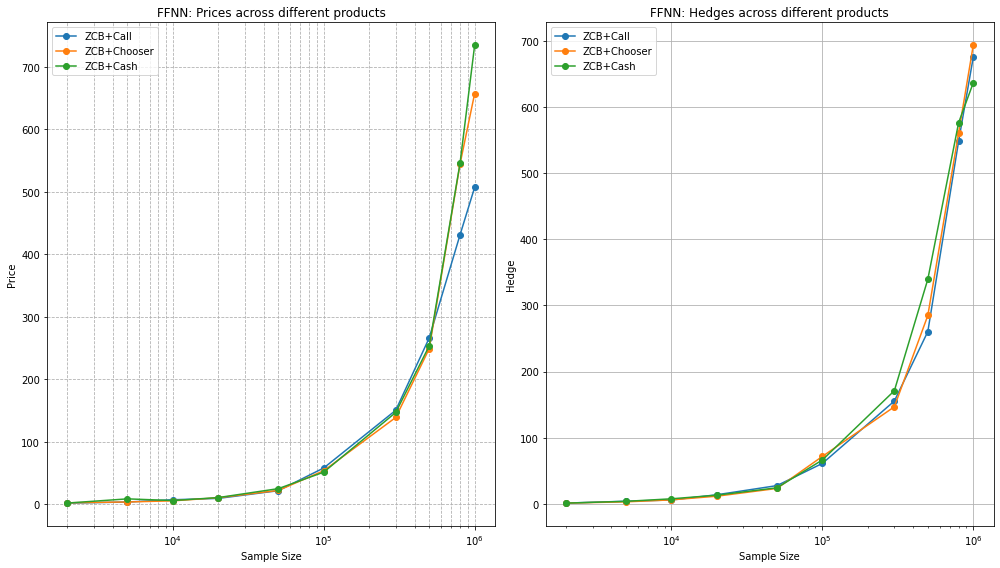

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Data
sample_sizes = np.array([2000, 5000, 10000, 20000, 50000, 100000, 300000, 500000, 800000, 1000000])

# Prices
prices_zcb_call = np.array([1.80, 3.54, 7.19, 9.34, 21.68, 58.08, 150.36, 266.11, 430.95, 507.05])
prices_zcb_chooser = np.array([2.30, 3.61, 5.45, 10.38, 22.14, 53.65, 138.86, 248.89, 544.24, 657.15])
prices_zcb_cash = np.array([1.89, 8.60, 5.88, 10.67, 24.97, 51.36, 146.89, 253.28, 545.48, 734.36])

# Hedges
hedges_zcb_call = np.array([1.23, 4.07, 5.93, 13.87, 27.68, 61.24, 155.53, 260.49, 548.32, 675.23])
hedges_zcb_chooser = np.array([1.25, 3.15, 6.15, 11.69, 23.37, 71.81, 146.84, 284.87, 560.87, 693.37])
hedges_zcb_cash = np.array([1.22, 3.90, 7.74, 13.19, 24.40, 66.39, 171.13, 339.67, 576.36, 636.56])

# Plotting
plt.figure(figsize=(14, 8))

# Prices
plt.subplot(1, 2, 1)
plt.plot(sample_sizes, prices_zcb_call, marker='o', label='ZCB+Call')
plt.plot(sample_sizes, prices_zcb_chooser, marker='o', label='ZCB+Chooser')
plt.plot(sample_sizes, prices_zcb_cash, marker='o', label='ZCB+Cash')
plt.title('FFNN: Prices across different products')
plt.xlabel('Sample Size')
plt.ylabel('Price')
plt.xscale('log')
plt.grid(True, which="both", ls="--")
plt.legend()

# Hedges
plt.subplot(1, 2, 2)
plt.plot(sample_sizes, hedges_zcb_call, marker='o', label='ZCB+Call')
plt.plot(sample_sizes, hedges_zcb_chooser, marker='o', label='ZCB+Chooser')
plt.plot(sample_sizes, hedges_zcb_cash, marker='o', label='ZCB+Cash')
plt.title('FFNN: Hedges across different products')
plt.xlabel('Sample Size')
plt.ylabel('Hedge')
plt.xscale('log')
plt.grid()
plt.legend()


plt.savefig("computational_times_ffnn.png", dpi=300)

plt.tight_layout()
plt.show()

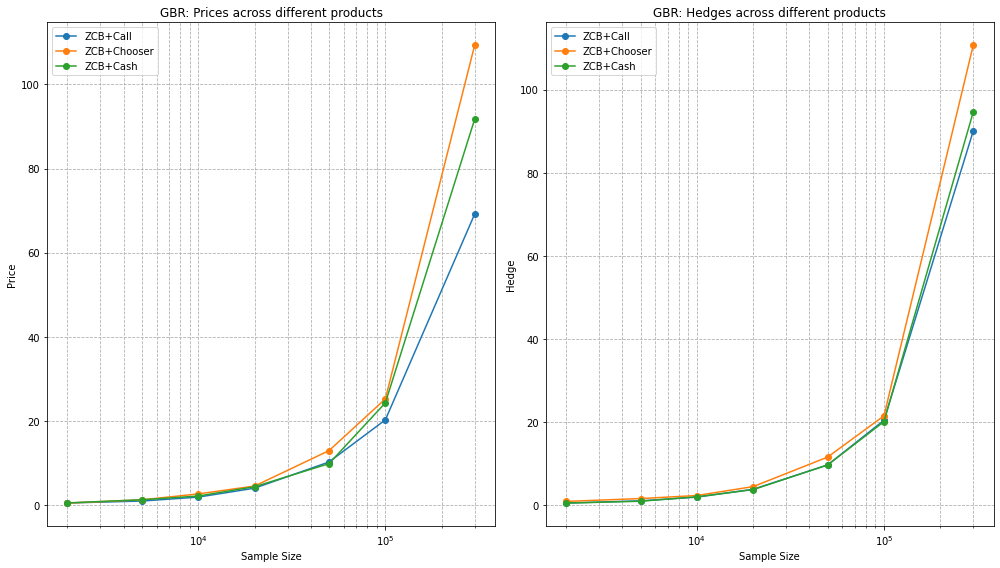

In [8]:
# GBR Data
sample_sizes_gbr = np.array([2000, 5000, 10000, 20000, 50000, 100000, 300000])

# Prices for GBR
prices_gbr_zcb_call = np.array([0.47, 0.93, 1.87, 3.99, 10.22, 20.24, 69.16])
prices_gbr_zcb_chooser = np.array([0.44, 1.22, 2.63, 4.50, 12.92, 25.22, 109.32])
prices_gbr_zcb_cash = np.array([0.49, 1.24, 2.12, 4.34, 9.83, 24.28, 91.72])

# Hedges for GBR
hedges_gbr_zcb_call = np.array([0.53, 1.07, 1.96, 3.85, 9.70, 20.45, 90.04])
hedges_gbr_zcb_chooser = np.array([0.93, 1.61, 2.35, 4.49, 11.59, 21.51, 110.67])
hedges_gbr_zcb_cash = np.array([0.52, 0.97, 2.04, 3.77, 9.70, 20.12, 94.62])

# Plotting GBR Data
plt.figure(figsize=(14, 8))

# Prices for GBR
plt.subplot(1, 2, 1)
plt.plot(sample_sizes_gbr, prices_gbr_zcb_call, marker='o', label='ZCB+Call')
plt.plot(sample_sizes_gbr, prices_gbr_zcb_chooser, marker='o', label='ZCB+Chooser')
plt.plot(sample_sizes_gbr, prices_gbr_zcb_cash, marker='o', label='ZCB+Cash')
plt.title('GBR: Prices across different products')
plt.xlabel('Sample Size')
plt.ylabel('Price')
plt.xscale('log')
plt.grid(True, which="both", ls="--")
plt.legend()

# Hedges for GBR
plt.subplot(1, 2, 2)
plt.plot(sample_sizes_gbr, hedges_gbr_zcb_call, marker='o', label='ZCB+Call')
plt.plot(sample_sizes_gbr, hedges_gbr_zcb_chooser, marker='o', label='ZCB+Chooser')
plt.plot(sample_sizes_gbr, hedges_gbr_zcb_cash, marker='o', label='ZCB+Cash')
plt.title('GBR: Hedges across different products')
plt.xlabel('Sample Size')
plt.ylabel('Hedge')
plt.xscale('log')
plt.grid(True, which="both", ls="--")
plt.legend()

plt.savefig("computational_times_gbr.png", dpi=300)

plt.tight_layout()
plt.show()

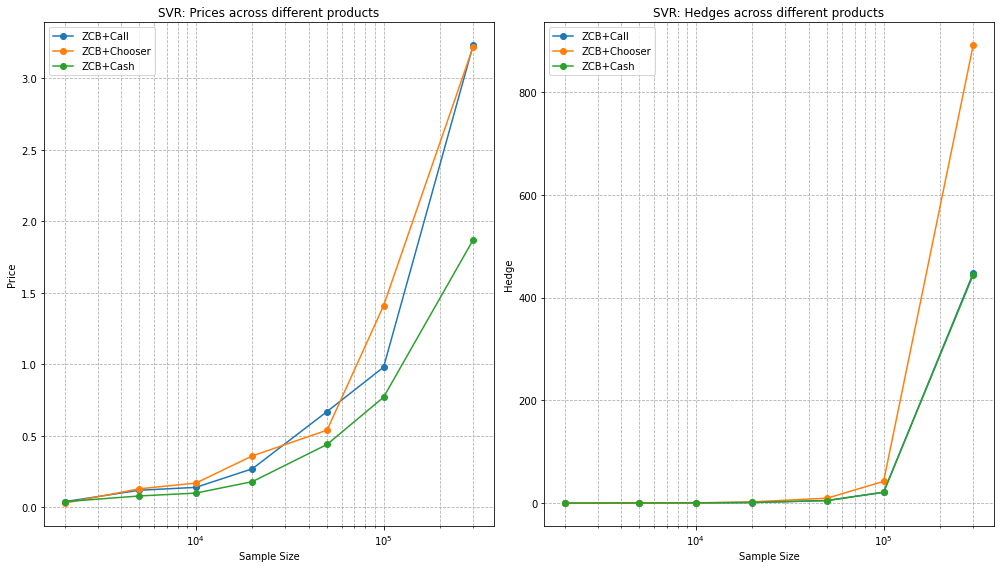

In [9]:
# SVR Data
sample_sizes_svr = np.array([2000, 5000, 10000, 20000, 50000, 100000, 300000])

# Prices for SVR
prices_svr_zcb_call = np.array([0.04, 0.12, 0.14, 0.27, 0.67, 0.98, 3.23])
prices_svr_zcb_chooser = np.array([0.03, 0.13, 0.17, 0.36, 0.54, 1.41, 3.22])
prices_svr_zcb_cash = np.array([0.04, 0.08, 0.10, 0.18, 0.44, 0.77, 1.87])

# Hedges for SVR
hedges_svr_zcb_call = np.array([0.05, 0.35, 0.45, 1.09, 5.27, 21.26, 447.38])
hedges_svr_zcb_chooser = np.array([0.07, 0.34, 0.46, 2.48, 9.64, 42.35, 891.22])
hedges_svr_zcb_cash = np.array([0.07, 0.28, 0.57, 1.38, 4.86, 21.11, 444.24])

# Plotting SVR Data
plt.figure(figsize=(14, 8))

# Prices for SVR
plt.subplot(1, 2, 1)
plt.plot(sample_sizes_svr, prices_svr_zcb_call, marker='o', label='ZCB+Call')
plt.plot(sample_sizes_svr, prices_svr_zcb_chooser, marker='o', label='ZCB+Chooser')
plt.plot(sample_sizes_svr, prices_svr_zcb_cash, marker='o', label='ZCB+Cash')
plt.title('SVR: Prices across different products')
plt.xlabel('Sample Size')
plt.ylabel('Price')
plt.xscale('log')
plt.grid(True, which="both", ls="--")
plt.legend()

# Hedges for SVR
plt.subplot(1, 2, 2)
plt.plot(sample_sizes_svr, hedges_svr_zcb_call, marker='o', label='ZCB+Call')
plt.plot(sample_sizes_svr, hedges_svr_zcb_chooser, marker='o', label='ZCB+Chooser')
plt.plot(sample_sizes_svr, hedges_svr_zcb_cash, marker='o', label='ZCB+Cash')
plt.title('SVR: Hedges across different products')
plt.xlabel('Sample Size')
plt.ylabel('Hedge')
plt.xscale('log')
plt.grid(True, which="both", ls="--")
plt.legend()

plt.savefig("computational_times_svr.png", dpi=300)

plt.tight_layout()
plt.show()